In [14]:
import os
import re
import sys
import math
import tqdm
import torch
import time
import datetime
import numpy as np
import pandas as pd
from typing import Union
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel 
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")

    fontsize = 28
    plt.subplots(figsize=(16, 9))
    plt.plot(df['Epoch'], df['Test RMSE'], label='Test RMSE', color='tab:blue', linewidth=3)
    plt.plot(df['Epoch'], df['Train RMSE'], label='Train RMSE', color='tab:orange', linewidth=3)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlim(-200, 5200)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylim(-0.05, 0.8)
    plt.legend(loc='center right', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')

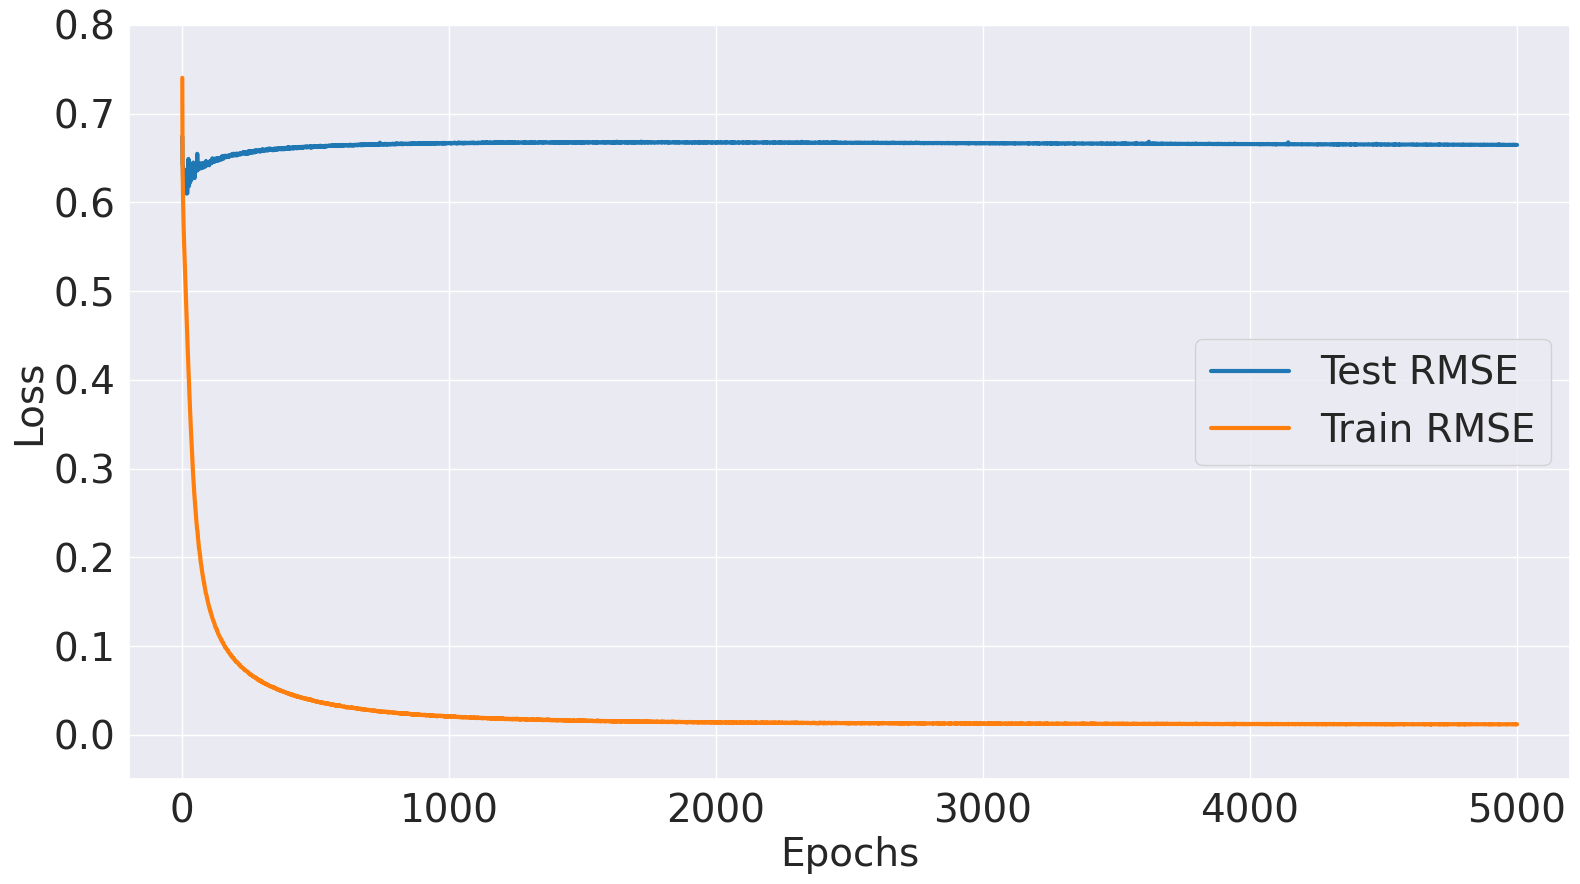

In [15]:
esm_binding_new_csv = "./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_15-24/esm_blstm-dms_binding-train_78797_test_19700_metrics.csv"
esm_binding_new_pdf = "./run_results/esm-blstm/esm_blstm-dms_binding-2024-08-20_15-24/esm_blstm-dms_binding-train_78797_test_19700_metrics.png"
plot_log_file(esm_binding_new_csv, esm_binding_new_pdf)

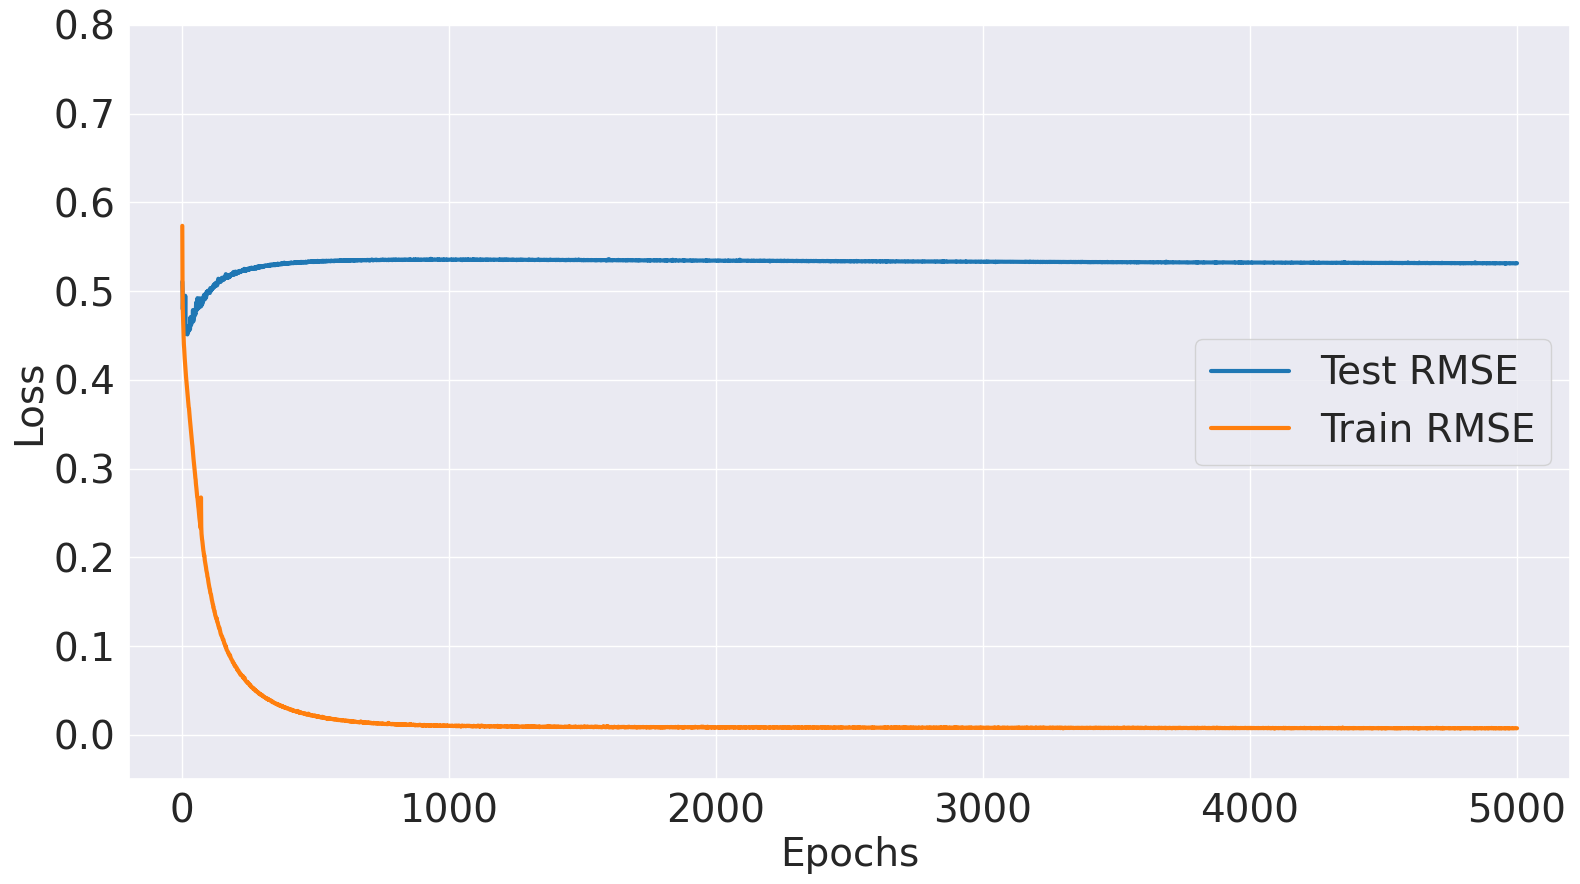

In [16]:
esm_expression_new_csv = "./run_results/esm-blstm/esm_blstm-dms_expression-2024-09-01_23-04/esm_blstm-dms_expression-train_83280_test_20821_metrics.csv"
esm_expression_new_pdf = "./run_results/esm-blstm/esm_blstm-dms_expression-2024-09-01_23-04/esm_blstm-dms_expression-train_83280_test_20821_metrics.pdf"
plot_log_file(esm_expression_new_csv, esm_expression_new_pdf)